Few key observations
- If both and non-encrypted files are base-32 encoded, accuracy drops really low.
   * Even in this case, fourier analysis (specifically autocorrelation and mean) provide good discrminators
   * Renyi's entropy at alpha=infinity gives good discrimination
   * Overall we see around 13% improvement in F1-score
- Specifically for webpfiles
   * We see that higher moments of around 14 gives a good discrimination
   * Fourier analysis still gives benefits here
- For webpfiles where both unencrypted and encrypted content are base32 encrypted
   * Fourier analysis is still beneficial
- For Non-webp files where plaintext is not base-32 encrypted
   * Accuracy is decent with just the base parameters, but with fourier analysis, we can close to perfect detection


# Contents
- ## [Implementation](#mplementation)
 - ### [List of Files](#list-of-files)
 - ### [Utility to call gc](#gc)
 - ### [Selection of Columns](#select-columns)
 - ### [Function to compare the three selections of columns for a given dataset](#compare-fn)
 - ### [Load the datasets](#load-dataset)
 - ### [Select the datasets](#dataset-selection)
 - ### [Run all combinations of data](#dataset-selection)
- ## [Results](#results)
 


## Implementation <a class="anchor" id="implementation">
    
[top](#Contents)

In [1]:
import pandas as pd
import numpy as np
import scipy
from scipy import stats

from functools import lru_cache

import gc

import sklearn
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, accuracy_score, recall_score

import matplotlib.pyplot as plt
import glob

import tqdm
from multiprocessing.pool import ThreadPool, Pool

plt.rcParams["figure.figsize"] = (20,20)

### List of files <a class="anchor" id="list-of-files">

[top](#Contents)

In [158]:
!ls

Iteration_2.1_EXT2_RF_CV5_compare_base32_logistic_regression.ipynb
expanded.plaintext.base32.csv.gz
expanded.pyencrypted_v1.b32.csv.gz
expanded.pyencrypted_v1.csv.gz
expanded.pyencrypted_v2.base32.csv.gz
expanded.pyencrypted_v2.csv.gz
iteration_2.1_compare_base32_alternate_encryption_scheme.ipynb
iteration_2.1_compare_base32_logistic_regression.ipynb
plaintext.base32.combined.csv.gz
plaintext.combined.csv.gz
plaintext.expanded.csv.gz


### Utility to call GC <a class="anchor" id="gc">
    
[top](#Contents)

In [159]:
def call_gc():
    for i in range(3):
        for j in range(3):
            gc.collect(j)

### Selection of columns <a class="anchor" id="select-columns">
    
This function is used to select the columns.
There are three different configurations:
    
    1. Baseline - statistics like autocorrelation, shannon entropy, chi-square etc. are used
    
    2. Advanced - More statistics like moments, Tsallis and Renyi entropy, higher moments etc.
    
    3. Fourier - Some statistics of the Fourier Power Spectrum distribution
    
[top](#Contents)

In [253]:
def get_columns(thisdf):
    baseline_columns = [c for c in thisdf.columns if c.startswith('baseline') and "head" not in c and "tail" not in c]
    baseline_columns = [c for c in baseline_columns if "filesize" not in c]
    baseline_columns = [c for c in baseline_columns if "begin" not in c and "end" not in c]

    advanced_columns = [c for c in thisdf.columns if "advanced" in c]
    advanced_columns = [c for c in advanced_columns if "begin" not in c and "end" not in c]
    advanced_columns = [c for c in advanced_columns if "head" not in c and "tail" not in c]
    advanced_columns = [c for c in advanced_columns if "start" not in c]
    advanced_columns_only = list(set(advanced_columns))
    advanced_columns = list(set(advanced_columns + baseline_columns))

    fourier_columns = [c for c in thisdf.columns if "fourier" in c and "value" not in c]
    fourier_columns = [c for c in fourier_columns if "1byte" in c]
    fourier_columns = [c for c in fourier_columns if "begin" not in c and "end" not in c]
    fourier_columns = [c for c in fourier_columns if "head" not in c and "tail" not in c]
    fourier_columns = [c for c in fourier_columns if "start" not in c]
    fourier_columns_only = list(set(fourier_columns))
    fourier_columns = list(set(advanced_columns + fourier_columns))
    
    baseline_and_advanced = list(set(baseline_columns + advanced_columns_only))
    baseline_and_fourier = list(set(baseline_columns + fourier_columns_only))
    advanced_and_fourier = list(set(advanced_columns_only + fourier_columns_only))
    
    return {\
        "fourier": fourier_columns,\
    }

### Function to compare the three selections of columns for a given dataset <a class="anchor" id="compare-fn">
    
For the three different sets of measurements described above, compare all the three sets for their f1 score
    
[top](#Contents)

In [254]:
USE_ASYNC = False
N_SPLITS=5

def get_weighted_feature_importances(f1_scores, feature_importances):
    """
    First scale the importances so that the column with the maximum
    importance has an importance 1.
    
    Next find the weighted mean w.r.t. the f1-score
    """
    out_importances = np.zeros(len(feature_importances[0]))
    for f1, importance in zip(f1_scores, feature_importances):
        importance = importance / np.max(importance)
        importance = importance * f1
        out_importances = out_importances + importance
    out_importances /= sum(f1_scores)
    return out_importances

def get_kfold_f1_score(name, collist, X, y):
    skf = StratifiedKFold(n_splits=N_SPLITS, random_state=42, shuffle=True)
    f1_scores = []
    precision_scores = []
    recall_scores = []
    accuracy_scores = []
    feature_importances = []
    X = X[collist].to_numpy()
    y = y.to_numpy()
    call_gc()
    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        rfc = RandomForestClassifier(n_jobs=10, random_state=42)
        estimators = [\
                      ('std,', MinMaxScaler()), \
                      ('RandomForestClassifier', rfc)]
        pipeline = Pipeline(estimators)
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        f1_scores.append(f1_score(y_test, y_pred))
        recall_scores.append(recall_score(y_test, y_pred))
        precision_scores.append(precision_score(y_test, y_pred, zero_division=0))
        accuracy_scores.append(accuracy_score(y_test, y_pred))
        feature_importances.append(rfc.feature_importances_)

    return name, \
            float(np.mean(f1_scores)),\
            float(np.mean(accuracy_scores)),\
            float(np.mean(precision_scores)),\
            float(np.mean(recall_scores)),\
            get_weighted_feature_importances(f1_scores, feature_importances)
            

def compare_feature_selections_async(X, y):
    columns_dict = get_columns(X)
    ret = dict()
    pool = Pool(3)
    async_results = list()
    for name, collist in columns_dict.items():
        result = pool.apply_async(\
                                  get_kfold_f1_score, \
                                  (name, collist, X, y))
    for result in async_results:
        name, f1 = result.get(timeout=None)
        ret[name] = f1
    return ret

def compare_feature_selections_sync(X, y):
    columns_dict = get_columns(X)
    ret = dict()
    for name, collist in columns_dict.items():
        name, f1, accuracy, precision, recall, fimp = \
            get_kfold_f1_score(name, collist, X, y)
        ret[f"{name}-f1_score"] = f1
        ret[f"{name}-accuracy_score"] = accuracy
        ret[f"{name}-precision_score"] = precision
        ret[f"{name}-recall_score"] = recall
        ret[f"{name}-feature_importances"] = fimp
    return ret

def compare_feature_selections(X, y):
    if USE_ASYNC:
        return compare_feature_selections_async(X, y)
    else:
        return compare_feature_selections_sync(X, y)

def compare_feature_selections_wrapper(data):
    X = data[[c for c in data.columns if "is_encrypted" != c]]
    y = data["is_encrypted"]
    return compare_feature_selections(X, y)


### Load the datasets <a class="anchor" id="load-dataset">

We don't want to load the datasets again and again, so we load them once.
The LRU cache ensures that the next time this is called, we don't load the datasets again.
    
[top](#Contents)

In [255]:
@lru_cache
def load_datasets_once():
    """Load all datasets only once
    
    We want to load the datasets only once. Once loaded
    serve from cache
    """
    datasets = dict()
    for file in glob.glob("*.csv.gz"):
        df = pd.read_csv(file)
        df = df.sample(frac=1).reset_index(drop=True)
        df["is_encrypted"] = 1 if "encr" in file.lower() else 0
        datasets[file] = df
    return datasets

### Select the datasets <a class="anchor" id="dataset-selection">

Select the dataset, combine it, shuffle it and return
    
We used several schemes:
* Plaintext
  - The base plaintext dataset of around 50k files
  - Expanded dataset, where all files that were less than 1500 bytes were expanded by repeating the file
  - Base32 encoding of
   - original plaintext
   - expanded plaintext
* Encryption : We used two schemes for encruption
  - v1 : AES 256 encryption of the full file, again two varieties were used
    - Plain encryption
    - Encryption followed by base32 encoding
  - v2 : AES encryption of the file, the first and the last 128 bytes are not encrypted. Of the remaining file, every alternate 16 bytes are encrypted.
    - Plain encryption
    - encryption followed by base32 encoding
    
We select combinations of the above datasets
    
Furthermore, we add further combinations by including and excluding webp files, and including and excluding non-webp files.
    
[top](#Contents)

In [256]:
def get_dataset(\
               exclude_plaintext_nonbase32=False,
               exclude_plaintext_base32=False,
               exclude_encrypted_v1=False,
               exclude_encrypted_v2=False,
               exclude_encrypted_base32=False,
               exclude_encrypted_nonbase32=False,
               exclude_webp=False,
               exclude_nonwebp=False):
    description = {k:v for k,v in locals().items() \
                   if "exclude" in k}
    
    files = glob.glob("*.csv.gz")
    
    
    if exclude_plaintext_nonbase32:
        files = [f for f in files if \
                     "plaintext" not in f \
                     or "_base32" in f \
                     or "_b32" in f]
    if exclude_plaintext_base32:
        files = [f for f in files if\
                    "plaintext" not in f or \
                    ("base32" not in f and "b32" not in f)]
    if exclude_encrypted_v1:
        files = [f for f in files if\
                    "_v1" not in f or "encr" not in f]
    if exclude_encrypted_v2:
        files = [f for f in files if \
                    "_v2" not in f or "encr" not in f]
    if exclude_encrypted_base32:
        files = [ f for f in files if\
                    "encr" not in f or\
                    ("base32" not in f and "b32" not in f)]
    if exclude_encrypted_nonbase32:
        files = [f for f in files if \
                    "encr" not in f or \
                    "base32" in f or "b32" in f]
        
        
    encrypted_count = len([f for f in files if "encr" in f])
    non_encrypted_count = len([f for f in files if "encr" not in f])
    
    if 0 == encrypted_count or 0 == non_encrypted_count or 0 == len(files):
        return description, None, -1, -1
    
    all_dfs = list()
    all_loaded_datasets = load_datasets_once()
    for filename in files:
        all_dfs.append(all_loaded_datasets[filename])
    
    combined_df = pd.concat(all_dfs)
    
    if exclude_webp:
        combined_df = combined_df[\
                        combined_df["extended.extension"] != ".webp"]
    if exclude_nonwebp:
        combined_df = combined_df[\
                        combined_df["extended.extension"] == ".webp"]
        
    if len(combined_df) == 0:
        return description, None, -1, -1
    
        
    encrypt_count = len(combined_df[combined_df["is_encrypted"] == 1])
    nonencrypted_count = len(combined_df[combined_df["is_encrypted"] == 0])

    
    if 0 == len(combined_df) or 0 == encrypt_count or 0 == nonencrypted_count:
        return description, None, -1, -1
    
    return description, combined_df, encrypt_count, nonencrypted_count

### Run all combinations of data <a class="anchor" id="dataset-selection">

For all combinations of the datasets, compare the three classes (basic, advanced, and Fourier)
    
[top](#Contents)

In [258]:
all_results = []
list_of_arguments = []

# Get all 8-tuple combinations of T/F
list_of_arguments = [(True,), (False,)]
for i in range(7):
    temp = []
    for e in list_of_arguments:
        et = e + (True,)
        temp.append(et)
        et = e + (False,)
        temp.append(et)
    list_of_arguments = temp

for a, b, c, k, e, f, g, h in tqdm.tqdm(list_of_arguments):
    desc, df, ec, nec = get_dataset(a, b, c, k, e, f, g, h)
    if df is not None:
        result = compare_feature_selections_wrapper(df)
        call_gc()
        result = {**desc, **result}
        result["n_encrypted"] = ec
        result["n_non_encrypted"] = nec
        result["ratio_encrypt_nonencrypt"] = float(ec) / nec
        all_results.append(result)


df_dict = {k:[] for k in all_results[0] if "feature_importance" not in k}
for result in all_results:
    for k, v in result.items():
        if "feature_importances" not in k:
            df_dict[k].append(v)


def get_weighted_importances_1(all_results):
    f1_colname = None
    importance_colname = None
    for k in all_results[0]:
        if "f1_score" in k:
            f1_colname = k
        if "feature_importance" in k:
            importance_colname = k
    f1_scores = []
    importances = []
    print(f1_colname, importance_colname)
    for result in all_results:
        f1_scores.append(result[f1_colname])
        importances.append(result[importance_colname])
    
    out_importances = np.zeros(len(importances[0]))
    for f1, imp in zip(f1_scores, importances):
        out_importances = out_importances + imp * f1
    out_importances = out_importances / sum(f1_scores)
    
    return out_importances

print(get_weighted_importances_1(all_results))



100%|██████████████████████████████████████████████████| 256/256 [1:16:26<00:00, 17.92s/it]

fourier-f1_score fourier-feature_importances
[8.03698271e-06 2.15789831e-01 2.70194746e-04 2.16152491e-01
 7.30919214e-03 2.53462846e-01 1.64230314e-01 2.39685437e-01
 2.96277061e-01 7.54116703e-02 3.46775065e-05 6.16855590e-04
 6.21699309e-01 6.73007331e-02 3.01895795e-01 1.21672786e-01
 2.60067730e-01 2.87891597e-03 6.27494486e-02 2.47979441e-01
 6.88173186e-02 2.69457548e-02 1.77641375e-02 5.57335763e-02
 3.10080155e-01 2.29997810e-02 3.81209436e-02 4.31917826e-01
 3.56319338e-01 7.42959466e-04 3.81606298e-06 1.97936722e-01
 2.66570355e-01 2.50058956e-01 6.85722333e-02 3.17941351e-01
 2.69969700e-01 6.26677158e-01 1.78205931e-01 5.67279693e-02
 1.18211121e-05 4.35405281e-01 2.58706852e-01 3.50133693e-01
 1.18848116e-04 1.59651728e-01 1.34268086e-01 2.18842218e-01
 1.90818961e-01 1.39688032e-03 4.52874851e-01 1.52548827e-01
 1.97724771e-01 1.19356903e-03 2.73452261e-01 4.11545638e-03
 5.29049393e-04 1.77866843e-01 1.43697552e-01 1.57917731e-01
 1.12284906e-01 7.73569791e-02 2.5515408

fourier-f1_score fourier-feature_importances


<AxesSubplot:xlabel='importances', ylabel='features'>

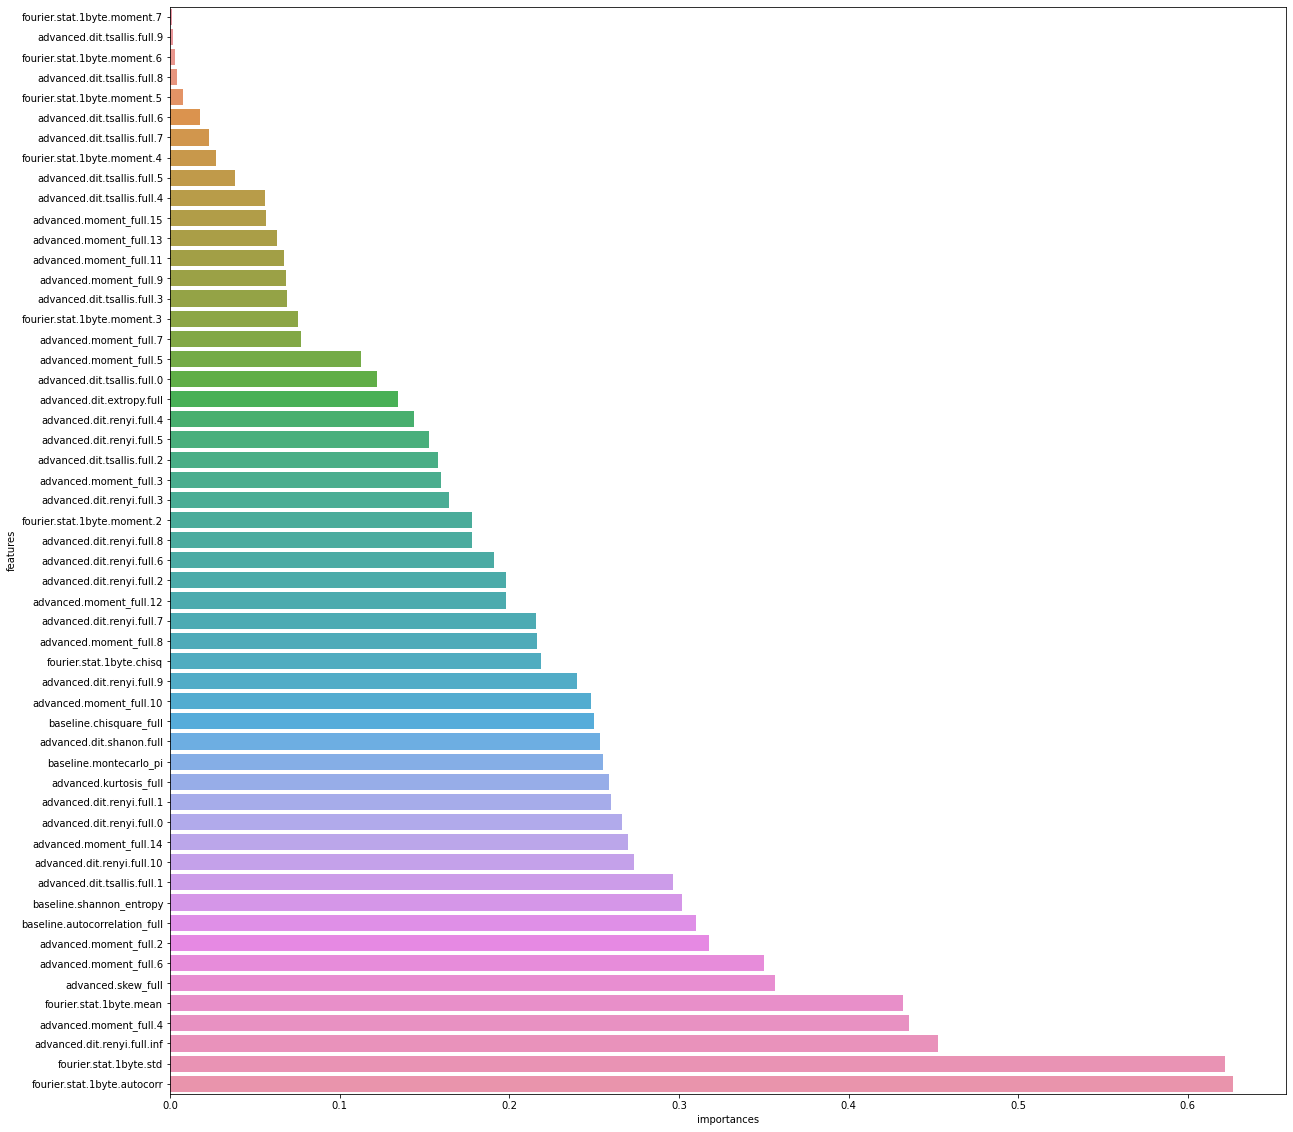

In [259]:
plt.rcParams["figure.figsize"] = (20,20)

columns = get_columns(df[[c for c in df.columns if "is_encrypted" != c]])["fourier"]

df2_dict = {"features": columns, "importances": get_weighted_importances_1(all_results)}
imp_df = pd.DataFrame(df2_dict)
imp_df = imp_df.sort_values(by="importances", ascending=True).reset_index(drop="True")
imp_df = imp_df[imp_df["importances"] > 0.001]
sns.barplot(y="features", x="importances", data=imp_df)

### Somewhat different weighted calculation

In the earlier weighted calculation, we had scaled each importance matrix
before calculating the weighted average.
in this one, we don't.


100%|██████████████████████████████████████████████████| 256/256 [1:15:23<00:00, 17.67s/it]


fourier-f1_score fourier-feature_importances
[5.71130889e-07 1.99137044e-02 2.07174968e-05 2.01127774e-02
 6.06305106e-04 2.35698080e-02 1.50342039e-02 2.15422741e-02
 2.82354436e-02 7.38141586e-03 2.47883564e-06 5.18310944e-05
 6.80792586e-02 6.01183102e-03 2.95695662e-02 1.34540196e-02
 2.44149634e-02 2.24514153e-04 5.48148691e-03 2.34724493e-02
 5.62718630e-03 2.36064729e-03 1.43224178e-03 4.96751303e-03
 2.98561476e-02 2.03235493e-03 3.11946709e-03 4.42895061e-02
 3.58879481e-02 6.18598226e-05 2.73590606e-07 1.84984465e-02
 3.11387565e-02 2.02087853e-02 6.09812831e-03 3.04275600e-02
 2.55042497e-02 6.36526943e-02 1.53765481e-02 4.75074762e-03
 7.88763790e-07 4.49721004e-02 2.34800610e-02 3.57413751e-02
 9.08775107e-06 1.27164219e-02 1.14791145e-02 2.02432364e-02
 1.74130403e-02 1.10286773e-04 4.02500457e-02 1.34222387e-02
 1.82096674e-02 9.61228022e-05 2.47866470e-02 3.33522193e-04
 4.35043350e-05 1.73819268e-02 1.27939439e-02 1.44152397e-02
 1.00734445e-02 6.78104084e-03 2.2776461

<AxesSubplot:xlabel='importances', ylabel='features'>

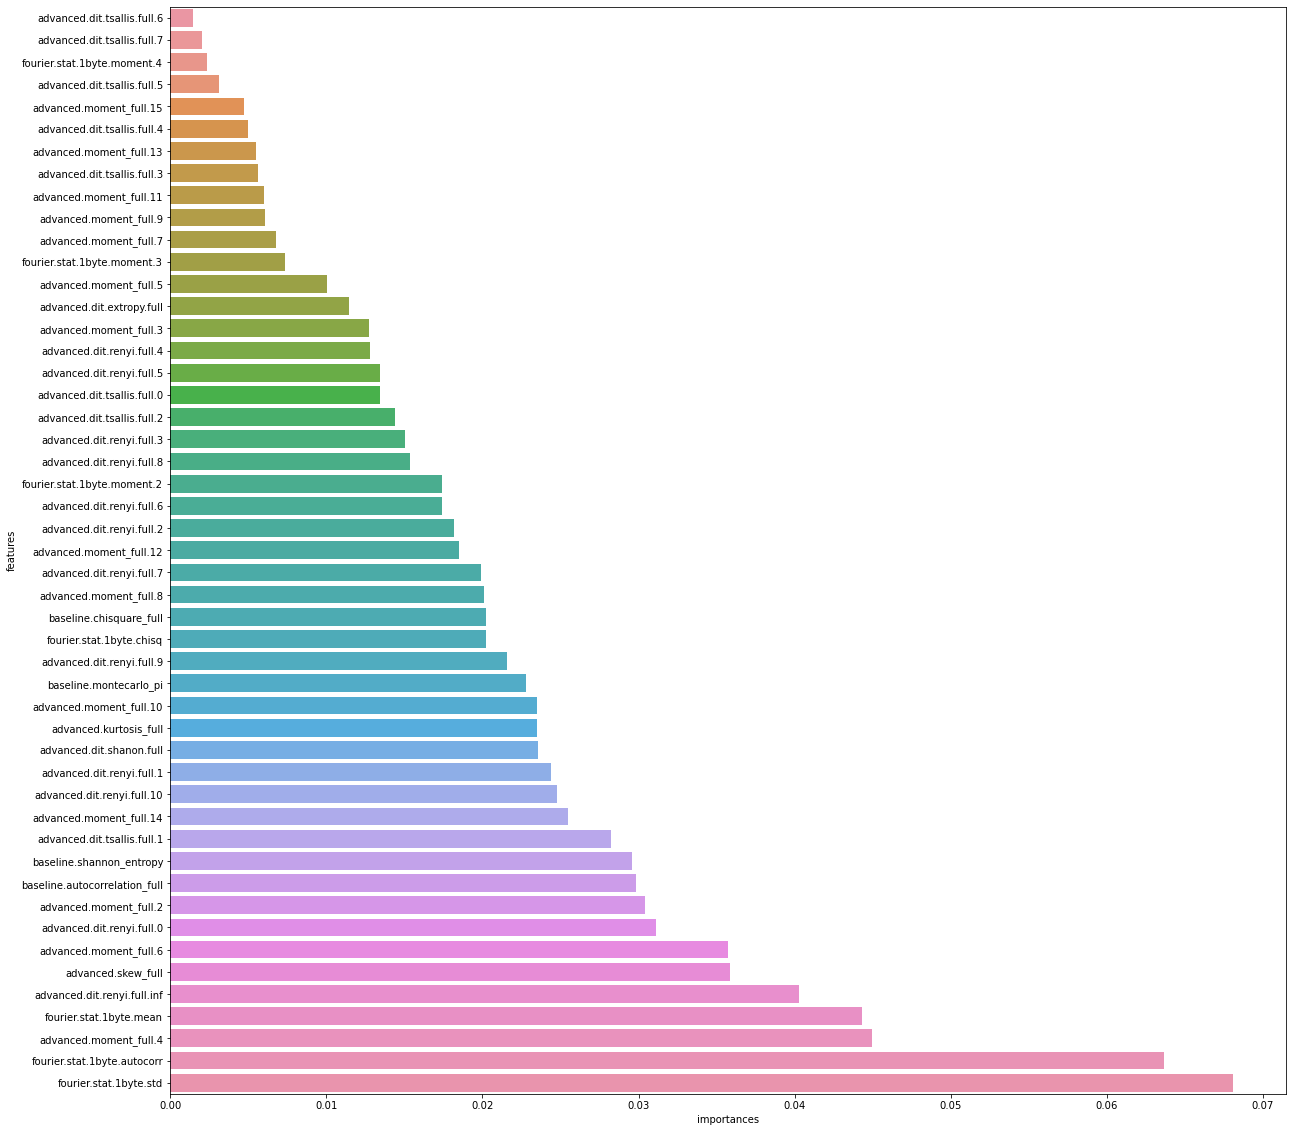

In [260]:
def get_weighted_feature_importances(f1_scores, feature_importances):
    """
    Redefined function
    
    Next find the weighted mean w.r.t. the f1-score
    """
    out_importances = np.zeros(len(feature_importances[0]))
    for f1, importance in zip(f1_scores, feature_importances):
        # importance = importance / np.max(importance)
        importance = importance * f1
        out_importances = out_importances + importance
    out_importances /= sum(f1_scores)
    return out_importances

all_results = []
list_of_arguments = []

# Get all 8-tuple combinations of T/F
list_of_arguments = [(True,), (False,)]
for i in range(7):
    temp = []
    for e in list_of_arguments:
        et = e + (True,)
        temp.append(et)
        et = e + (False,)
        temp.append(et)
    list_of_arguments = temp

for a, b, c, k, e, f, g, h in tqdm.tqdm(list_of_arguments):
    desc, df, ec, nec = get_dataset(a, b, c, k, e, f, g, h)
    if df is not None:
        result = compare_feature_selections_wrapper(df)
        call_gc()
        result = {**desc, **result}
        result["n_encrypted"] = ec
        result["n_non_encrypted"] = nec
        result["ratio_encrypt_nonencrypt"] = float(ec) / nec
        all_results.append(result)


df_dict = {k:[] for k in all_results[0] if "feature_importance" not in k}
for result in all_results:
    for k, v in result.items():
        if "feature_importances" not in k:
            df_dict[k].append(v)


def get_weighted_importances_1(all_results):
    f1_colname = None
    importance_colname = None
    for k in all_results[0]:
        if "f1_score" in k:
            f1_colname = k
        if "feature_importance" in k:
            importance_colname = k
    f1_scores = []
    importances = []
    print(f1_colname, importance_colname)
    for result in all_results:
        f1_scores.append(result[f1_colname])
        importances.append(result[importance_colname])
    
    out_importances = np.zeros(len(importances[0]))
    for f1, imp in zip(f1_scores, importances):
        out_importances = out_importances + imp * f1
    out_importances = out_importances / sum(f1_scores)
    
    return out_importances

print(get_weighted_importances_1(all_results))


plt.rcParams["figure.figsize"] = (20,20)

columns = get_columns(df[[c for c in df.columns if "is_encrypted" != c]])["fourier"]

df2_dict = {"features": columns, "importances": get_weighted_importances_1(all_results)}
imp_df = pd.DataFrame(df2_dict)
imp_df = imp_df.sort_values(by="importances", ascending=True).reset_index(drop="True")
imp_df = imp_df[imp_df["importances"] > 0.001]
sns.barplot(y="features", x="importances", data=imp_df)

In [264]:
print(columns)

['fourier.stat.1byte.moment.14', 'advanced.dit.renyi.full.7', 'fourier.stat.1byte.moment.10', 'advanced.moment_full.8', 'fourier.stat.1byte.moment.5', 'advanced.dit.shanon.full', 'advanced.dit.renyi.full.3', 'advanced.dit.renyi.full.9', 'advanced.dit.tsallis.full.1', 'fourier.stat.1byte.moment.3', 'fourier.stat.1byte.moment.12', 'fourier.stat.1byte.moment.9', 'fourier.stat.1byte.std', 'advanced.moment_full.11', 'baseline.shannon_entropy', 'advanced.dit.tsallis.full.0', 'advanced.dit.renyi.full.1', 'fourier.stat.1byte.moment.6', 'advanced.moment_full.13', 'advanced.moment_full.10', 'advanced.dit.tsallis.full.3', 'fourier.stat.1byte.moment.4', 'advanced.dit.tsallis.full.6', 'advanced.dit.tsallis.full.4', 'baseline.autocorrelation_full', 'advanced.dit.tsallis.full.7', 'advanced.dit.tsallis.full.5', 'fourier.stat.1byte.mean', 'advanced.skew_full', 'fourier.stat.1byte.moment.8', 'fourier.stat.1byte.moment.15', 'advanced.moment_full.12', 'advanced.dit.renyi.full.0', 'baseline.chisquare_full'

In [265]:
for c in columns:
    print(c)

fourier.stat.1byte.moment.14
advanced.dit.renyi.full.7
fourier.stat.1byte.moment.10
advanced.moment_full.8
fourier.stat.1byte.moment.5
advanced.dit.shanon.full
advanced.dit.renyi.full.3
advanced.dit.renyi.full.9
advanced.dit.tsallis.full.1
fourier.stat.1byte.moment.3
fourier.stat.1byte.moment.12
fourier.stat.1byte.moment.9
fourier.stat.1byte.std
advanced.moment_full.11
baseline.shannon_entropy
advanced.dit.tsallis.full.0
advanced.dit.renyi.full.1
fourier.stat.1byte.moment.6
advanced.moment_full.13
advanced.moment_full.10
advanced.dit.tsallis.full.3
fourier.stat.1byte.moment.4
advanced.dit.tsallis.full.6
advanced.dit.tsallis.full.4
baseline.autocorrelation_full
advanced.dit.tsallis.full.7
advanced.dit.tsallis.full.5
fourier.stat.1byte.mean
advanced.skew_full
fourier.stat.1byte.moment.8
fourier.stat.1byte.moment.15
advanced.moment_full.12
advanced.dit.renyi.full.0
baseline.chisquare_full
advanced.moment_full.9
advanced.moment_full.2
advanced.moment_full.14
fourier.stat.1byte.autocorr
adv